<a href="https://colab.research.google.com/github/XUideaList/Validating-Ampere-s-law-with-PINN/blob/main/Validating_Ampere's_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Verifying the validity of Ampere's law experimetally

# The part that exploits PINN is in development
I am uploading this for preparation purposes addition to the suggestion of the following idea: using PINN for interpolation involving Convolutions


The following code was inspired by the experiment originally designed by PASCO - Ampere's law. Here, we will be reinforcing the logic of the given experiment using various methods.

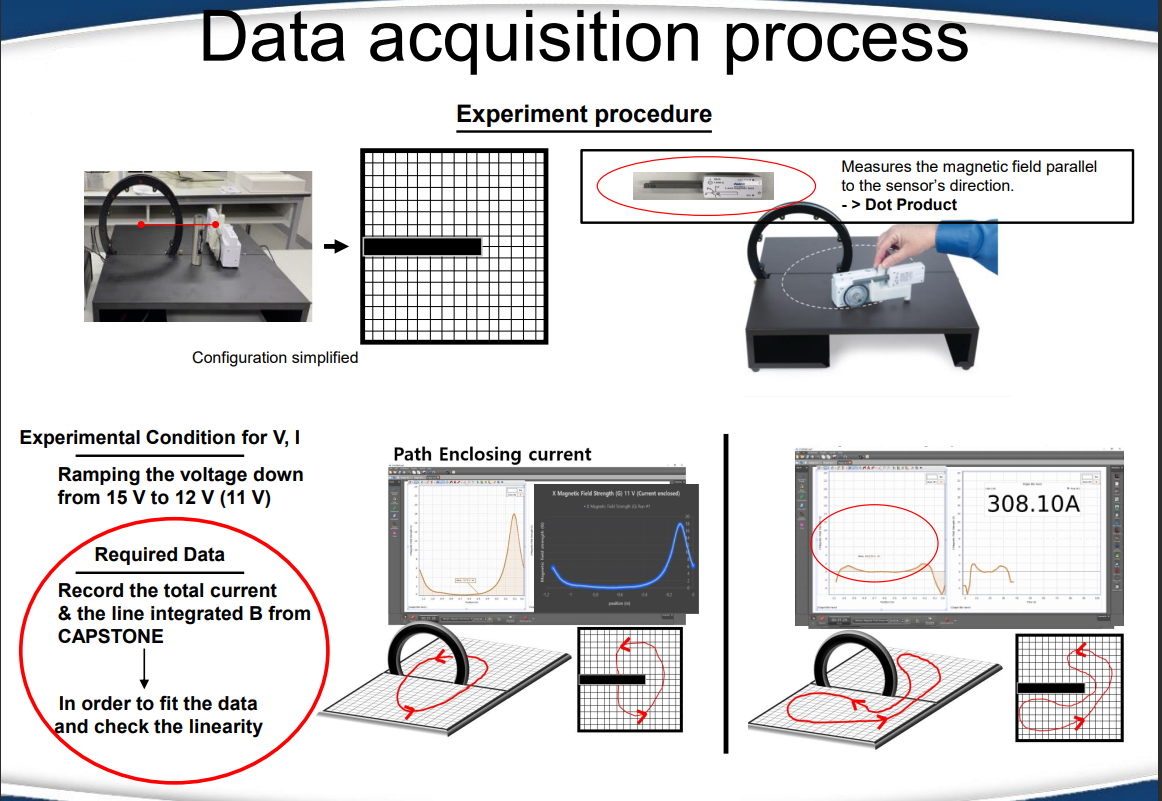

As shown in the figure above, The experiment trys to show the validity of Ampere's law by mounting a magnetic field sensor to a cart with the rotary sensor attached to its wheel. Using the CAPSTONE program, we are enable to access the magnetic field strength data with respect to the distance the cart moved. Here the experiment requires the path integrated field data for different paths, one with the path enclosing the coil and the other that doesn't. Eventually, we can check the validity of Ampere's law (In the integration version) by comparing with the acquired data.

However, such data are limited to the paths that the cart moved. The main point is that we should show that the consistency stands for an arbitrary path, which lacks reliability of our logic.

Therefore I've constructed another method to verify Ampere's law within the configuration by involving the experimental data.

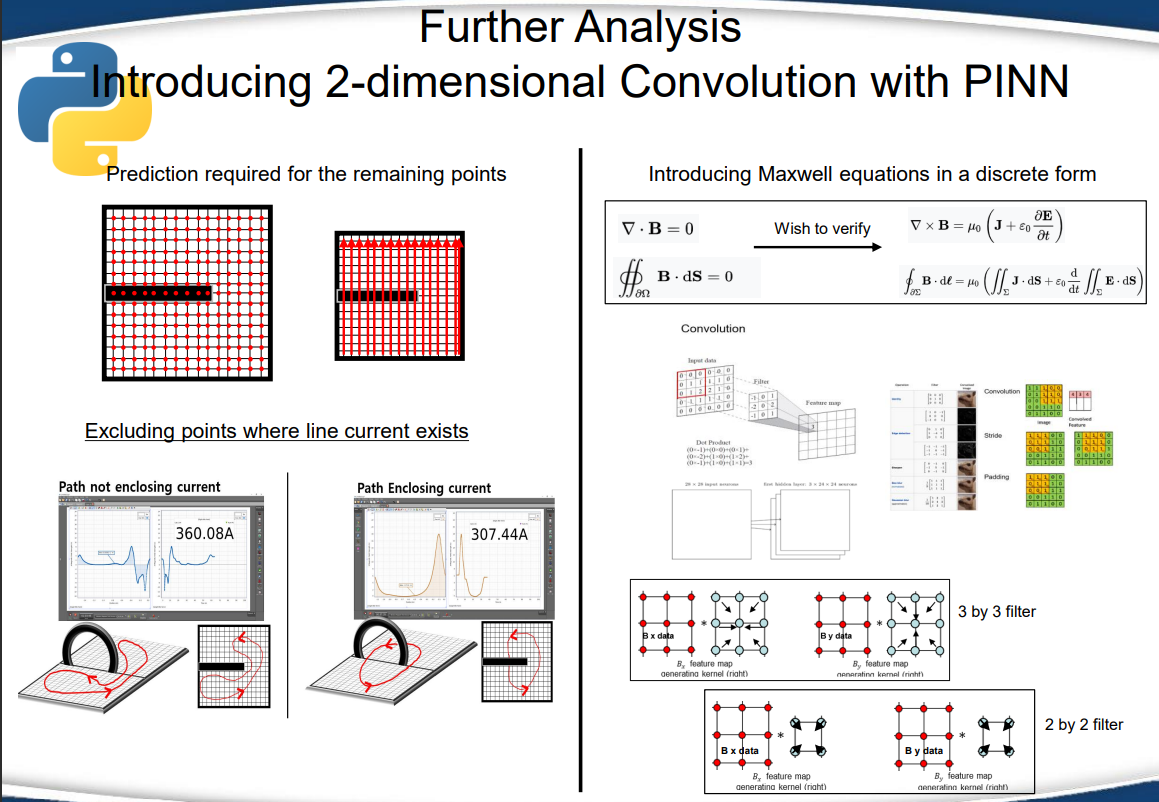

Unlike the original method, I will be using the differentiated version of Ampere's law. The data collecting procedure would also be modified as shown in the figure above. We would be collecting a 10 by 10 grid B field data which would be in a form of 2x10x10 tensor(or 10x10x2). After, 2 dimensional convolution will be introduced in order to evaluate the divergence of the magnetic field. For such process, I've managed to use the filters for evaluation of divergence using convolution as the filters shown in the figure above. (specifically, this code would be using a 2x2 filter)

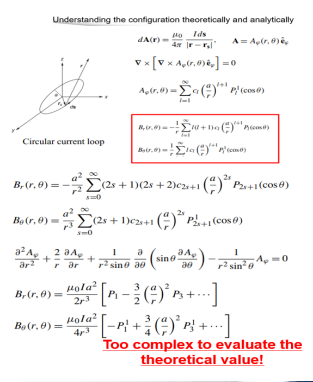

Note that the original field generated by the current loop of the experiment is complex to evaluate since it involves "**Associated Legendre polynomials**" in a form of "**infinite series**". So we would be first using a toy model using two current flowing line wires and then using experimental data for evaluation.

This also indicates that such method would be convenient to analyze fields that are complex to plot (just by using theoretical anlaysis.)

# Generating the Toy model for evaluation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [ ]:
a = 0.10715
ring_w = 0.016
W = 0.46
slot_step = 10 #int(input(" How many data points collected in a n by n form:  "))
# This represents the number of data points that will be collected for a single row and the number of rows where the data will be collected.
d = W/slot_step
I_ampere = 400 # A
mu = 4*np.pi*10E-7 #H/m

print("\n the configuration has a form of", W,"*",W, " m\n with a current loop of width", ring_w
      , " m. \n and the radius in average as", a , " m. \n required data points in total would be ", int(slot_step**2)
      , " in total. \n So the width of the measuring points would be : ", d ," m"
      , "total current within the configuration: ", I_ampere, " A")


 the configuration has a form of 0.46 * 0.46  m
 with a current loop of width 0.016  m. 
 and the radius in average as 0.10715  m. 
 required data points in total would be  100  in total. 
 So the width of the measuring points would be :  0.046  m total current within the configuration:  400  A


#Constructing the configuration: ACtual configuration(Left) & Estimated field (Right)

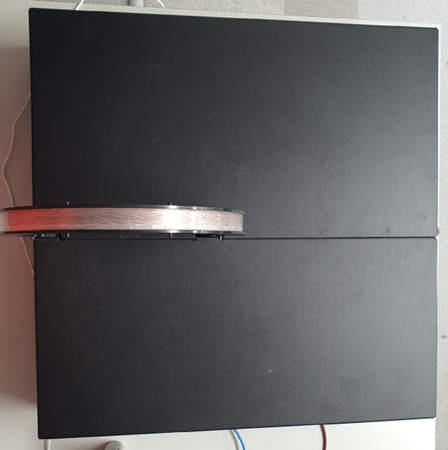
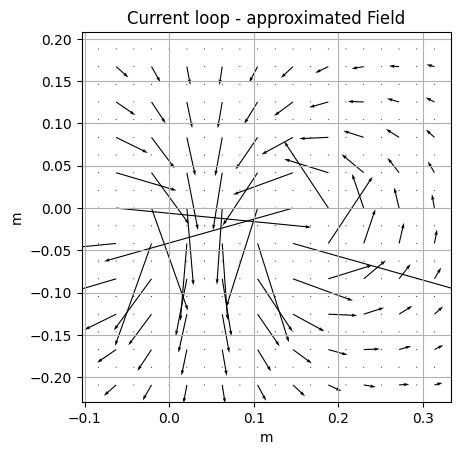

In [ ]:
# Simple situation
x_s = np.arange(-0.0418*2, 0.0418*8, 0.0418)
y_s = np.arange(0.0418*4+0.0209, -0.0209-0.0418*5, -0.0418)  # The number 0.0418 comes from the horizontal position of the current line.
d1 = -0.0418*2      # the x-coordinate of the current line.
d2 =  0.15 -0.0209  # the x-coordinate of the other current line.

position_sh = np.tile(x_s,(10,1))
position_sv = np.tile(y_s,(10,1))
position_s=[]   # storing the data in cartesian (grid form)

for index_sh in range(0,10):
  for index_sv in range(0,10):
    position_s.append([position_sh[index_sh][index_sv], position_sv[index_sh][index_sh]])
position_s = np.reshape(np.asarray(position_s),(10,10,2))  # saving the grid position data in a tensor form


position_rd1 = []   # the square of the distance from the right current line.
position_rd2 = []   # the square of the distance from the left current line.

for index_r1 in range(0,10):
  for index_r2 in range(0,10):
    position_rd1.append((position_s[index_r1][index_r2][0]-d1)**2+position_s[index_r1][index_r2][1]**2)
    position_rd2.append((position_s[index_r1][index_r2][0]-d2)**2+position_s[index_r1][index_r2][1]**2)

position_rd1 = np.reshape(np.asarray(position_rd1), (10,10))
position_rd2 = np.reshape(np.asarray(position_rd2), (10,10))

Now the field for the toy model. it is based on the field produced by a line current.

In [ ]:
I_simple = 400  # Amperes
s_c = mu*I_simple/(2*np.pi)

B_h= []
B_v= []

for index_1 in range(0,10):
  for index_2 in range(0,10):
    B_h.append(s_c/(position_rd1[index_1][index_2])*(position_s[index_1][index_2][1])
    + -s_c/(position_rd2[index_1][index_2])*(position_s[index_1][index_2][1]))

    B_v.append(-s_c/(position_rd1[index_1][index_2])*(position_s[index_1][index_2][0]-d1)
    + s_c/(position_rd2[index_1][index_2])*(position_s[index_1][index_2][0]-d2))

B_h = np.reshape(np.asarray(B_h), (10,10))
B_v = np.reshape(np.asarray(B_v), (10,10))

B=[]


for index_sh in range(0,10):
  for index_sv in range(0,10):
    B.append([B_h[index_sh][index_sv],B_v[index_sh][index_sv]])
B_toy = np.reshape(np.asarray(B),(10,10,2))
B_compare = np.asarray([B_h,B_v])

#Plotting the toy field

Now we will plot the field vectors as shown on the section below. Note that the red dots on the plotted figure represents the points where the data are collected while the green dots represent the points where the interpolation procedure  will be done.

In [ ]:
mag = 71 # interpolation(magnifying) coefficient, code revision required
s = 9 #the number of slots between rows and columns of the collected field data within the configuration.
N = mag*s
NS = s*mag+1

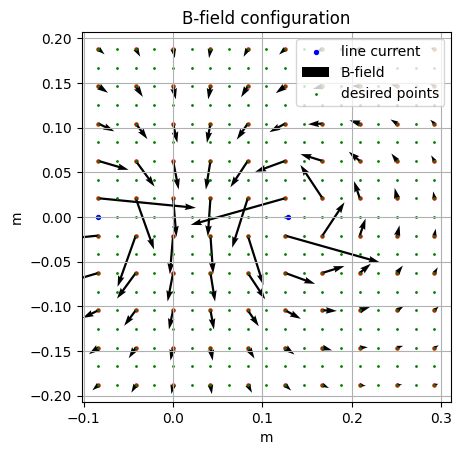

In [ ]:
# Define grid coordinates

x = np.arange(-0.0418*2, 0.0418*8, 0.0418)
y = np.arange(0.0418*4+0.0209, -0.0209-0.0418*5, -0.0418)
X, Y = np.meshgrid(x, y)

xx = np.arange(-0.0418*2, 0.0418*8, 0.0209)
yy = np.arange(0.0418*4+0.0209, -0.0209-0.0418*5, -0.0209)
XX, YY = np.meshgrid(xx, yy)


# Create the figure and axes
fig, ax = plt.subplots()
# plotting the space
for index_pl1 in range(0,10):
  for index_pl2 in range(0,10):
    plt.scatter(position_s[index_pl1][index_pl2][0],position_s[index_pl1][index_pl2][1], color='red', s=5)

# position of the current lines
plt.scatter(d1,0, color='blue', s=8)
plt.scatter(d2,0, color='blue', s=8, label='line current')

# Plot the vector field
scale=0.5
#ax.quiver(X, Y, B_sh, B_sv)
ax.quiver(X, Y, B_toy[:,:,0], B_toy[:,:,1], label='B-field') # Note that the toy data is stored in a form of 10x10x2 tensor

# Set plot title and labels
ax.set_title("B-field configuration")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

plt.grid('on')
plt.xlabel('m')
plt.ylabel('m')
# Show the plot

xx = np.arange(-0.0418*2, 0.0418*8, 0.0209)
yy = np.arange(0.0418*4+0.0209, -0.0209-0.0418*5, -0.0209)

for index_pl3 in range(0,19):
  for index_pl4 in range(0,19):
    plt.scatter(xx[index_pl3],yy[index_pl4], color='green', s=1)

plt.scatter(xx[0],yy[0], color='green', s=1, label='desired points')
plt.legend(loc=1)

plt.show()

Note that the field plotting section will be defined using a user defined function.

#Convolution section

In [ ]:
def convolution_2D(input, kernel):
  # data and kernel size declaration for convolution process
  data_height, data_width = input.shape
  kernel_height, kernel_width = kernel.shape
  # evaluating the linear combination using specific kernels
  output = np.zeros((data_height - kernel_height + 1, data_width - kernel_width + 1))
  for i in range(output.shape[0]):
      for j in range(output.shape[1]):
          output[i, j] = np.sum(input[i:i+kernel_height, j:j+kernel_width] * kernel)
  return(output)  # The output would be in a form of np.array

Comment After revision: *Actually it would've been better to introduce padding in the first place so that the convoled results using div_kernel & curl_kernel would give the values for the desired points. Yet, I will leave it just to be sure that the code remains well so...

Another possible way for convolution


     # import torch
     # import torch.nn as nn

     #  def convol_2d(input, kernel): # input would be the field grid data while kernel indicates the filter used for the convolution process
      #  input = torch.from_numpy(input).unsqueeze(0).unsqueeze(0).float()
       # kernel = torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0).float()
    # #create convolution layer
     # conv = nn.Conv2d(1,1, kernel_size = kernel.shape[2:])
      # Set kernel weights
    # with torch.no_grad():
      #   conv.weight = nn.Parameter(kernel)

    # Perform convolution
    # output = conv(input)
    # output = output.squeeze().numpy()

    return output


As we've brought the method of convolution to our code, we are now going to define the functions that would evaluate the divergence and the curl of the given field.

In [ ]:
# h for horizontal, v for vertical component
dia = np.sqrt(1/2)
# divergence convolution: computing the outward sum of the vector components with a 2x2 sized kernel
div_kernel_h = np.array([[-dia, +dia], [-dia, dia]])
div_kernel_v = np.array([[dia, dia], [-dia, -dia]])
div_kernel=[div_kernel_h, div_kernel_v]

curl_kernel_h = np.array([[-dia, -dia], [dia, dia]])
curl_kernel_v = np.array([[-dia, dia], [-dia, dia]])
curl_kernel=[curl_kernel_h, curl_kernel_v]


#div_kernel_h = div_kernel[0]
#div_kernel_v = div_kernel[1]

 Testing the generated filters using the defined 2d_Convolution function

In [ ]:
#testing convolution########################################################################################
kernel_set = [[div_kernel_h, div_kernel_v],[curl_kernel_h, curl_kernel_v]]

# set test_dumset to 1 if testing procedure is necessary
test_dumset=1
if(test_dumset):
  in_dum_x = np.array([[-dia,-1,-dia],[0,0,0],[dia,1,dia]])
  in_dum_y = np.array([[dia,0,-dia],[1,0,-1],[dia,0,-dia]])
  input_dum = [in_dum_x, in_dum_y]  # swirling field generated

  for index_k in range(0,2):
    for index_dumdum in range(0, 2):
      print(convolution_2D(input_dum[index_dumdum], kernel_set[index_k][index_dumdum]), "\n"*3)


[[-0.20710678  0.20710678]
 [ 0.20710678 -0.20710678]] 



[[-0.20710678  0.20710678]
 [ 0.20710678 -0.20710678]] 



[[1.20710678 1.20710678]
 [1.20710678 1.20710678]] 



[[-1.20710678 -1.20710678]
 [-1.20710678 -1.20710678]] 





Normally (or theoretically) the divergence of swirling fields should be zero. Yet, we can see that it shows a nonzero value for the test code.** This is because numerical methods in order to evaluate differentiated values require small step sizes hence, causing such significant error**

Yet, since we will be applying the code for experimental data, it is expected that there will be less error than it is shown in the test code.

#Defining the physical errors using Gauss's Law for magnetic fields
Note that only the divergence term will be used for the learning process. The curl error map is to check if the code runs without problems.

In [ ]:
import torch
import matplotlib.ticker as ticker

plotting function for the error tensors (Plotting the Divergence and Curl of the fields)

In [ ]:
def plot_field(torch_te, interpolation_coefficient=mag, show_option=1):
# the input would be in a form of torch_tensor
# Be aware that the input tensor shoud have its shape as 2x10x10
  np_te = np.asarray(torch_te.detach()) # detach and change it to numpy array (I'm not sure why detach kicked in,,,)
  # Create the figure and axes
  fig, ax = plt.subplots()
  # Plot the vector field

  x_config = np.linspace(-0.0418*2, 0.0418*7,(s)*mag+1,endpoint=True)
  y_config = np.linspace(0.0418*4+0.0209, -0.0209-0.0418*4,(s)*mag+1,endpoint=True)
  X_config, Y_config = np.meshgrid(x_config, y_config)

  scale=0.5#/(interpolation_coefficient**2)
  ax.quiver(X_config, Y_config, np_te[0], np_te[1], label='B field line')
  # Set plot title and labels
  ax.set_title("approximated Field, interpolation coefficient: {}".format(mag))
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  # Set aspect ratio to 'equal'
  ax.set_aspect('equal')

  # position of the current lines
  plt.scatter(d1,0, color='blue', s=8)
  plt.scatter(d2,0, color='blue', s=8, label='line current source')

  plt.grid('on')
  plt.xlabel('X-[m]')
  plt.ylabel('Y-[m]')

  plt.legend(loc=1)
  if(show_option):
    plt.show()



In [ ]:
def plot_del(torch_te, color=1, interpolation_coefficient=mag, slot_size=s, show_option=1):
  # Here the input will also be in a form of torch_tensor, del stands for the del operator
  np_te = np.asarray(torch_te.detach()) # detach and change it to numpy array

  #Desired size of the interpolated configuration: N-1, index: N-2
  N= interpolation_coefficient*slot_size+1
  #color 1 for divergence, 0 for curl
  if(color):
    plt.imshow(np_te, cmap='hot')
    dd_err = np.sum(np_te) #the input tensor already converted the elements into positive numbers
    plt.title("Div map, interpolation coefficient :%d, error: %.3e"%(interpolation_coefficient, dd_err), fontsize=10)

  else:
    plt.imshow(np_te, cmap='ocean')
    #a function that would actually sum the curl values near the current source.
    plt.title("Curl map, interpolation coefficient :{}".format(interpolation_coefficient),fontsize=10)


  plt.colorbar()

  plt.xlabel('X - index number')
  plt.ylabel('Y - index number')
  plt.gca().invert_yaxis()
  plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))
  plt.grid(True, color='white', linewidth=0.2)
  x_ticks = np.arange(0, (slot_size)*interpolation_coefficient+1, interpolation_coefficient)
  y_ticks = np.arange(0, (slot_size)*interpolation_coefficient+1, interpolation_coefficient)
  plt.xticks(x_ticks, fontsize=7.5*N/N)
  plt.yticks(y_ticks, fontsize=7.5*N/N)

  if(NS<100):
    for ite in range(0,(slot_size)*interpolation_coefficient+1):
      for ite2 in range(0,(slot_size)*interpolation_coefficient+1):
        if((ite2+1)%interpolation_coefficient==1 and ite%interpolation_coefficient==0):
          plt.scatter(ite,ite2, color='orange', s=1)
        else:
          plt.scatter(ite,ite2, color='purple', s=1)

  # position of the current lines

  # should consider the position with indices. Also, note that the filter used in the convolution
  # process doesn't remain the shape of the configuration.

  # distinguishing the points in a matter of interpolation and ML
  plt.scatter(0,0, color='orange', s=1, label="training point")
  plt.scatter(0,1, color='purple', s=1, label = "prediction point")
  plt.legend(loc=1)
  # 그래프 표시
  if(show_option):
    plt.figure(dpi=300)
    plt.show()

In [ ]:
def Div_error(input_original,  pl_option=0, error_option=0):
#(using the divergence filter) in a form of numpy array or torch_tensor.
# If pl_option is set to 1, it would plot the convoled divergence tensors in a form of a c-map.
  input = np.asarray(input_original)
  div_err_h = np.pad(convolution_2D(input[0], div_kernel_h), pad_width=1, mode='constant')
  div_err_v = np.pad(convolution_2D(input[1], div_kernel_v), pad_width=1, mode='constant') # padding

  div_err_matrix = div_err_h+div_err_v
# changing the divergence values all in positive numbers for error implementation process
  div_err_matrix = np.where(div_err_matrix<0, -div_err_matrix, div_err_matrix)
  div_err = np.sum(div_err_matrix)

  if(pl_option): # generating the plot of divergence if wanted
    plot_del(torch.Tensor(div_err_matrix))

  if(error_option):
    return div_err
  else:
    return torch.from_numpy(div_err_matrix);



def  Curl_error(input_original, pl_option=0):  # similar structure from Div_error function
  input = np.asarray(input_original)
  curl_err_h = np.pad(convolution_2D(input[0], curl_kernel_h), pad_width=1, mode='constant')
  curl_err_v = np.pad(convolution_2D(input[1], curl_kernel_v), pad_width=1, mode='constant')

  curl_err_matrix = curl_err_h+curl_err_v

  if(pl_option):
    plot_del(torch.Tensor(curl_err_matrix))

  return torch.from_numpy(curl_err_matrix)

(640, 640)


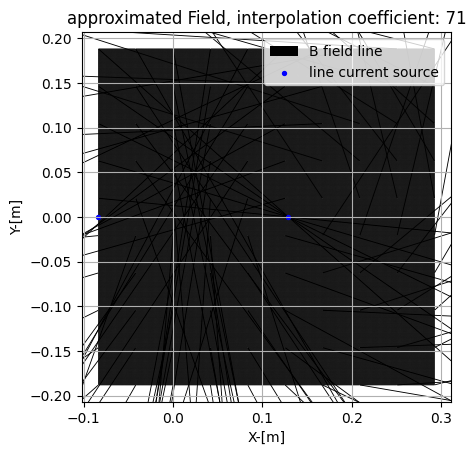

In [ ]:
B_compare=torch.Tensor(B_compare)

predicting_Bh  =  np.zeros((N+1,N+1))
predicting_Bv  =  np.zeros((N+1,N+1)) #s*mag+1
print(np.shape(predicting_Bh))
#norm = np.sqrt(np.max(np.square(B_h)+np.square(B_v))) # I've normalized the vector sizes just in case. If something goes wrong(like in the learning process)
# I recommend changing the norm into unity.

predicting_Bv[::mag,::mag] = B_v#/norm
predicting_Bh[::mag,::mag] = B_h#/norm

overall_B_in=torch.Tensor(np.asarray([predicting_Bh,predicting_Bv])) # 2x((s-1)*mag+1)x((s-1)*mag+1) tensor
# Plotting the toy field section declares the field data in a form of (mag*s)x(mag*s)*2 tensor.
# Be awared that the shape of the field tensor is modified in this section.

#using the function defined in the previous section
plot_field(overall_B_in)

And the following are the actual fields that lies on the desired points, meaning that it includes the points that should be restored by interpolation

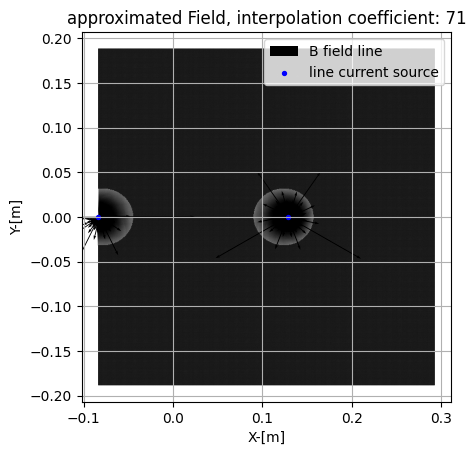

torch.Size([2, 640, 640])


In [ ]:
x_mag = np.linspace(-0.0418*2, 0.0418*7,(s)*mag+1,endpoint=True)
y_mag = np.linspace(0.0418*4+0.0209, -0.0209-0.0418*4,(s)*mag+1,endpoint=True)
#d1 = -0.0418*2       the x-coordinate of the current line.
#d2 =  0.15 -0.0209   the x-coordinate of the other current line.


position_magh = np.tile(x_mag,(NS,1))
position_magv = np.tile(y_mag,(NS,1))

position_mag=[]   # storing the data in cartesian (grid form)

for index_sh in range(0,NS):
  for index_sv in range(0,NS):
    position_mag.append([position_magh[index_sh][index_sv], position_magv[index_sh][index_sh]])
position_mag = np.reshape(np.asarray(position_mag),(NS,NS,2))  # saving the grid position data in a tensor form


position_rmag1 = []   # the square of the distance from the right current line.
position_rmag2 = []   # the square of the distance from the left current line.

for index_r1 in range(0,NS):
  for index_r2 in range(0,NS):
    position_rmag1.append((position_mag[index_r1][index_r2][0]-d1)**2+position_mag[index_r1][index_r2][1]**2)
    position_rmag2.append((position_mag[index_r1][index_r2][0]-d2)**2+position_mag[index_r1][index_r2][1]**2)

position_rmag1 = np.reshape(np.asarray(position_rmag1), (NS,NS))
position_rmag2 = np.reshape(np.asarray(position_rmag2), (NS,NS))
B_acth= []
B_actv= []

for index_1 in range(0,NS):
  for index_2 in range(0,NS):
    B_acth.append(s_c/(position_rmag1[index_1][index_2])*(position_mag[index_1][index_2][1])
    + -s_c/(position_rmag2[index_1][index_2])*(position_mag[index_1][index_2][1]))

    B_actv.append(-s_c/(position_rmag1[index_1][index_2])*(position_mag[index_1][index_2][0]-d1)
    + s_c/(position_rmag2[index_1][index_2])*(position_mag[index_1][index_2][0]-d2))

B_acth = np.reshape(np.asarray(B_acth), (NS,NS))
B_actv = np.reshape(np.asarray(B_actv), (NS,NS))

B_act=np.asarray([B_acth,B_actv])
B_act=torch.Tensor(B_act)

plot_field(B_act)
print(B_act.size())

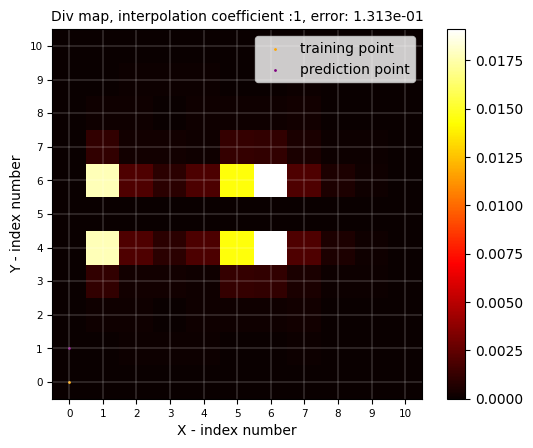

<Figure size 1920x1440 with 0 Axes>

0.13127550522403408


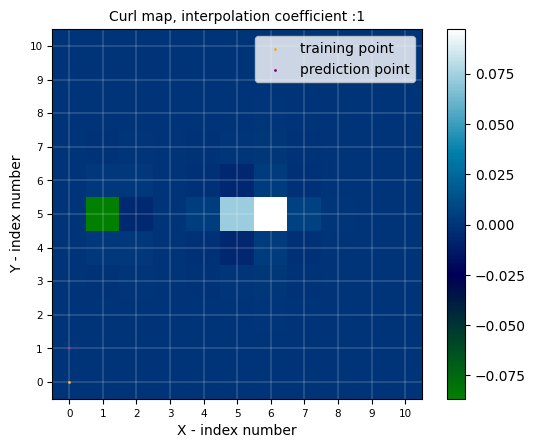

<Figure size 1920x1440 with 0 Axes>

tensor(0.0971, dtype=torch.float64)
tensor(-0.0866, dtype=torch.float64)


In [ ]:
CD=Div_error(B_compare,0,0)
CC=Curl_error(B_compare,0)


plot_del(CD,1,1,10,1)
print(Div_error(B_compare,0,1))
plot_del(CC,0,1,10,1)

print(torch.max(CC))
print(torch.min(CC))

In [ ]:
#Filled_div = Div_error(B_act,0,1)
#print("\n")
#Filled_curl = Curl_error(B_act)
#print(torch.max(Filled_curl))
#print(torch.min(Filled_curl))
#print(Filled_div)

Error maps with incomplete field data


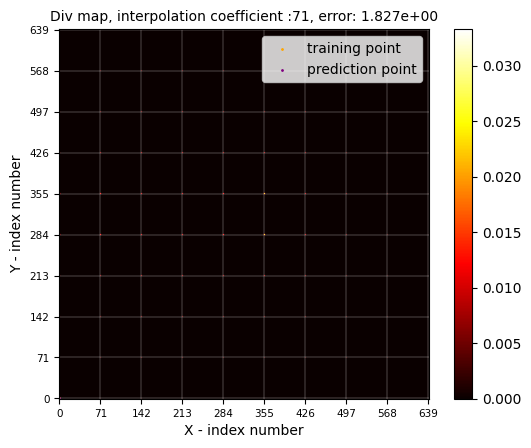

<Figure size 1920x1440 with 0 Axes>

Divergence error:  1.8271648614047846




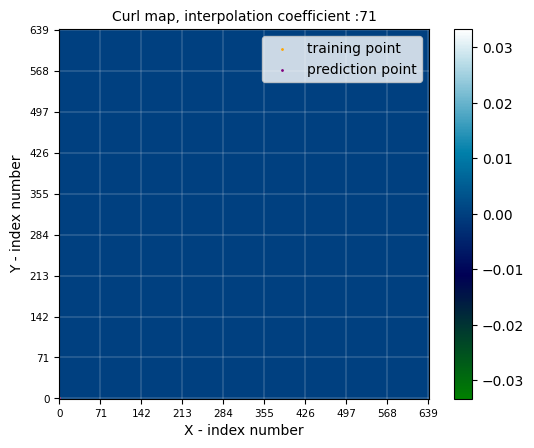

<Figure size 1920x1440 with 0 Axes>

tensor(0.0333, dtype=torch.float64)
tensor(-0.0333, dtype=torch.float64)


In [ ]:
#empty tensor in order to guess the magnetic field

initial_input_div = Div_error(overall_B_in)
initial_input_curl = Curl_error(overall_B_in)

print("Error maps with incomplete field data")

plot_del(initial_input_div,1)
print("Divergence error: ",Div_error(overall_B_in,0,1))
print('\n')
plot_del(initial_input_curl,0)

print(torch.max(initial_input_curl))
print(torch.min(initial_input_curl))

And these are the results where interpolation is done for given "mag"

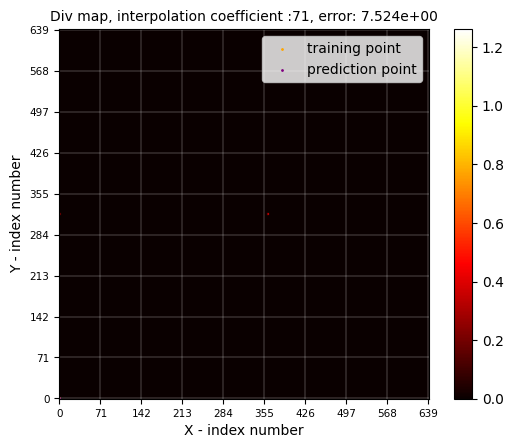

<Figure size 1920x1440 with 0 Axes>

Divergence error:  7.524456427580981




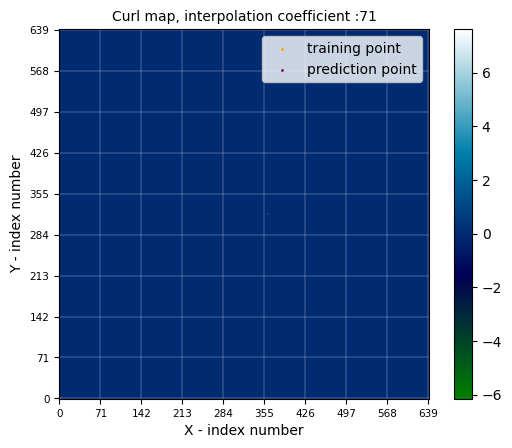

<Figure size 1920x1440 with 0 Axes>

tensor(7.6213, dtype=torch.float64)
tensor(-6.1495, dtype=torch.float64)


In [ ]:
#tensor filled unlike the previous example

Filled_div = Div_error(B_act)
print("\n")
Filled_curl = Curl_error(B_act)

plot_del(Filled_div,1)
print("Divergence error: ",Div_error(B_act,0,1))
print('\n')
plot_del(Filled_curl,0)
print(torch.max(Filled_curl))
print(torch.min(Filled_curl))


#Actual experimental results

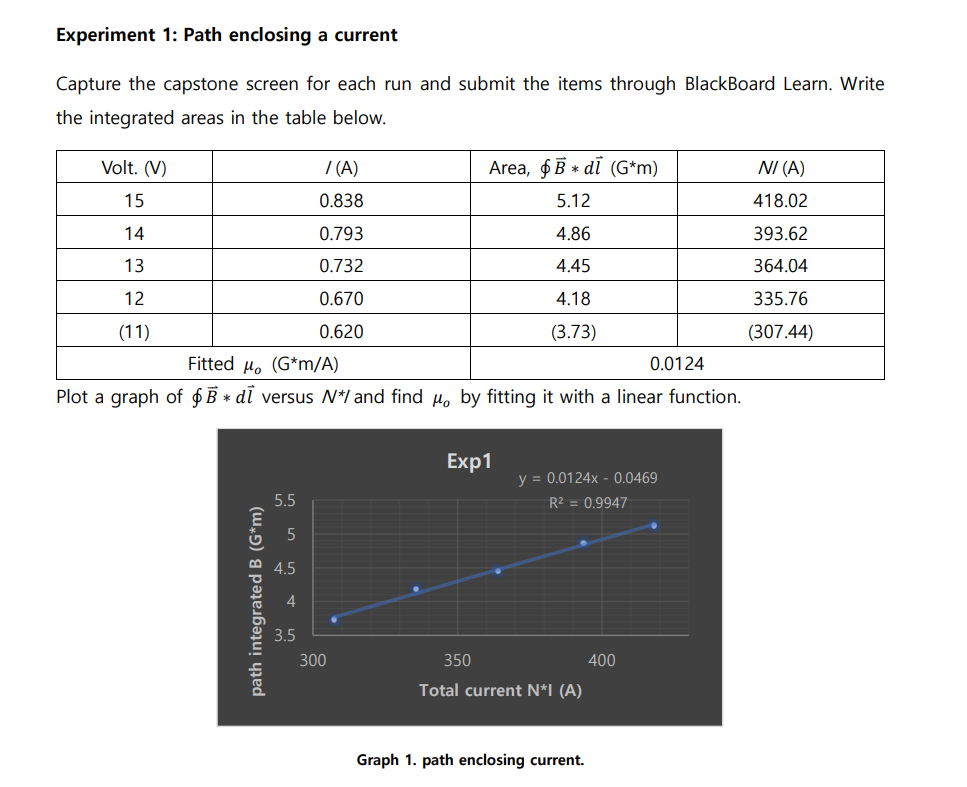

# Results for different Interpolation coefficient

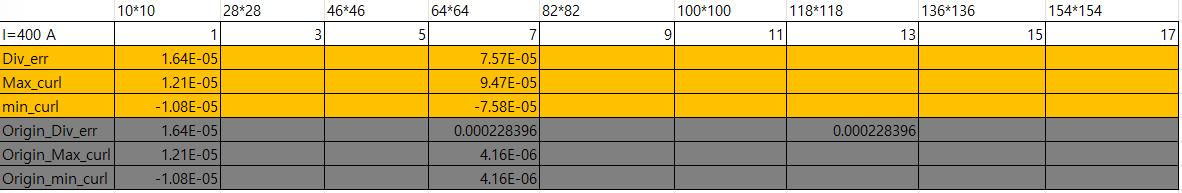

*Refer to https://docs.google.com/spreadsheets/d/1fd1RoHTrA-LQs3Di2oDhoObfbsI2rEpM/edit?usp=drive_link&ouid=107840157351743673732&rtpof=true&sd=true for more data and details of the curl and divergence data for different current and interpolation coefficient


 Be aware that the physical dimension is remained, meaning that the physical length of the configuration represented in the figures above is remained to be same regardless of the increment of the index numbers

* Even if the Divergence of the field isn't completely zero from the configuration, we can see that Ampere's law seem valid from the figure above. It would be more fascinating if we could cherry-pick the curl value enclosing the current source.

note that for the curl error tensor, the source on the right generates a curl product that flows toward us, while the left souce generates a curl vector that flows away from us

From the plotted error tensors above, we can see that the values near the current line shows significant values. Yet, we also can see that there are some unintended errors too. (for example, green areas exist on the right soource etc.)

Also, we can see that the divergence of the field isn't zero as it is closer to the source. This is due to the large field strength near the source and the "insufficiently" small step size, meaning that the estimation of for the results of applying differentiating operators have unnegligible error. This is expected to be vanished during the interpolation process since the step size would naturally decrease as the distance between each data point decreases. (roughly and awkwardly, we can guess that as the desired interpolated data consists of numerous data points, the error would decrease)

Hence, I will be counting on the learning process using the Neural Network that would weaken such unintended error by modifying the learning rates.

#Main - Interpolation procedure using Neural Network structures

Testing the defined functions

We will be now using the Neural Network structure in order to proceed the interpolation for our obtained data.

Basic structure of our desired model:           
Input : 2 x 10 x 10 -> 2x N x N with vacant space (containing the data as 0)              
Output: 2 x N x N  where N > 10  with all the previous vacant space filled up with generated field data    



In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# B_toy : 10x10x2
# overall_B_in  : 2xNxN

#Interpolation without the inspired method (For comparison)

In [ ]:
'''
class InterpolationModel(nn.Module):
    def __init__(self):
        super(InterpolationModel, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, fixed_data):
        out = self.conv(x)
        out[:, :, mag, mag] = fixed_data  # collected experimental data fixed
        out = self.relu(out)
        return out

model = InterpolationModel()

# 입력 데이터 준비 (2*N*N 크기의 텐서, (n,n) 위치에만 데이터가 채워져 있음)
#Preparing input data
input_data = overall_B_in
fixed_data = input_data[:, :, mag, mag].clone()  # (n,n) 위치 데이터 복사

# plugging the input data and the fixed data in order to fill the rest
output = model(input_data, fixed_data)

# checking the output
# print(output.shape)
plot_field(output)
'''

#Interpolation with ordinary (flatten) Neural Network

Autoencoder as an interpolator
https://arxiv.org/pdf/2101.00853.pdf

In [ ]:
# with the assumption the input has a form of 2x10x10 tensor



# If the input had a form of a 10x10x2 tensor, the code should be revised as the following
#
#
#

# The loss determined by the divergence is already defined using the Div_error function
# div_loss = Div_error(output)

#Interpolation with Autoencoder & PINN

Defining the Neural Network structure (Autoencoder + additional loss for the NN from div B = 0 )

In [ ]:
'''
class Autoencoder_Grey(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(N*N, 20*20), # NN recommended to be smaller than 60 and larger than 20
        nn.ReLU(),
        nn.Linear(20*20,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3)
        )  # Feature in 3 -dimensions

    self.decoder = nn.Sequential(
      nn.Linear(3,12),
      nn.ReLU(),
      nn.Linear(12,64),
      nn.ReLU(),
      nn.Linear(64,128),
      nn.ReLU(),
      nn.Linear(128,20*20),
      nn.ReLU(),
      nn.Linear(20*20, N*N),
      nn.Sigmoid() #Values between 0~1 per pixel are returned for the final output.
      )

  def forward_grey(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded
'''

Encoder for interpolation

In [ ]:
class Autoencoder(nn.Module):
  self.encoder = nn.Sequential(
      nn.Conv2d(3, 16, 7, stride=3, padding=1),
      nn.ReLU(True),
      nn.Conv2d(16,32,7, stride = 3, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, 3, stride = 2, )


  )


  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

defining losses for training process

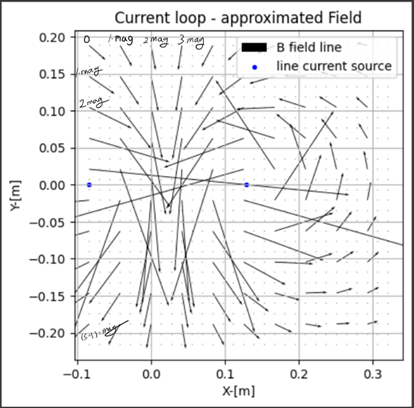

Note that errors should be evaluated from the data in positions of (n * mag, n * mag) where 0 <= n < s

In [ ]:
def tensor_loss(input_tensor, output_tensor): #MSE Form
  # Assuming the original tensor input has its form as 2 x N x N
  summed_h, sumed_v = 0 , 0
  for iter in range(s):
    summed_h += np.abs(output_tensor[0][mag*iter][mag*iter]-input_tensor[0][mag*iter][mag*iter])
    summed_v += np.abs(output_tensor[1][mag*iter][mag*iter]-input_tensor[1][mag*iter][mag*iter])
  summed = summed_h + summed_v
  return summed

GIF constructing function

In [ ]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


def plot_my_field(new_field, ps=None):
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)

    fig.suptitle(plot_name, fontsize=10)
    # variable "plot_name" will be defined later when calling the actual function

    # field configuration
    plt.subplot(3,1,1)
    plot_field(new_field, mag, 0)
    # plot 표시 조정
    l = plt.legend(loc=('upper left'), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.axis("off")

    plt.subplot(3,1,2)
    plot_del(new_field,1,mag,s,0)

    plt.subplot(3,1,3)
    plot_del(new_field,0,mag,s,0)

#def plot_my_del(new_field, ps=none):
#  fig = plt.figure(figsize=(16,8))
#  ax = fig.add_subplot(111)
#  fig.suptitle(del_name, fontsize=10)


#Training process

In [ ]:
%matplotlib inline
import time
torch.manual_seed(123)

#Hyper Parameter
lr = 0.001
div_lr = 1 # lr for divergence error
tot_epoch = 500
plot_num = 500
bookmark = int(tot_epoch/plot_num)

files=[]
file_name = input("file name to store the field GIF: ")
plot_name = 'Interpolated field with CNN_encoder: lr %s, divergence_lr %s'%(lr, div_lr)
gif_name = '/content/drive/MyDrive/Colab Notebooks/AI Physics textbook projects/23-2 project folder/Ampere\'s law/Interpolation_field_lr_data_%s_lr_physics_%s_episodes_%s.gif'%(lr, div_lr, tot_epoch)

#########
autoencoder_model = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr)

def train(autoencoder, experimental_data):
  autoencoder_model.train() #learning mode

  # 고정할 데이터는 고정
  encoded_data, decoded_data = autoencoder_model(experimental_data)
  # 고정했던 데이터는 학습 과정에서 제외할 수 있게 해야 함. -> 안 그래도 되지 않나..? 아직 생각 제대로 안해봄
  loss =  tensor_loss(experimental_data, decoded_data) + Div_error(experimental_data, 0, 1) * div_lr

  optimizer.zero_grad() # reset
  # proceed
  loss.backward()
  optimizer.step()



In [ ]:
#Execute Autoencoder
start = time.time()
for epoch in range(tot_epoch):
  train(autoencoder_model, overall_B_in)
  encoded_data, decoded_data = autoencoder_model(input)

  print("Number of trials: {}".format(epoch))
  if(epoch%bookmark==0):
    plot_my_field(decoded_data)
    file = file_name + "/interpolation_%.8i.png"%(epoch)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=300, facecolor="white")
    files.append(file)

    if (epoch % tot_epoch)==0: plt.show()
    else: plt.close("all")

print("duration for learning: %s [s]"% round(time.time()-start))

#Interpolation with CNN & PINN (may be segmented to the previous section)

#Expected Effects

As mentioned in the introduction, there are situations where the data colection process isn't easy and where the numerical predictions require complicated calculations.(such as the field generated by the current loop. It can be obtained by evaluating the infinite series consisting of terms of Associated Legendre polynomials)


Hence, such method has potential to provide proper predictions for fields where theoretical prediction can't be converted into completely accurate data. Also, as seen from the simulations above, as the desired grid size gets larger, the more accurate it becomes for the estimated value since the step size decreases when evaluating the divergence and curl via convolution. (Of course, a proper size is recommended since as it gets larger, the error based on the divergence won't affect much during the learning process.)

Such method can be expected to be used in weather forecasting. It is known that for global climate prediction, data collection is in progress from all around the globe by distinguishing the Earth in multiple sections. In other words, the climate data collection process is done by viewing the Earth as grid (as we have done for the field interpolation in the above). Yet, such methods are unstable since the distance between each data point is unnegligible. This is where the method comes in. As we introduce several equations describing the fluid's motinon (tides, wind etc.) or the thermal flow as a form of error, It would make this model capable of estimating the data where the actual data collecting probes are absent, hence providing a better result for forecasting.      

#[Optional] proceeding it with actual experimental data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filename_exp_1 = #row
filename_exp_2 = #column